<a href="https://www.kaggle.com/code/wenceslaoespinosa/u-net-breast-cancer-cnn?scriptVersionId=166404764" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Índice

1. [Introducción](#introducción)
2. [Configuración Inicial](#configuración-inicial)
3. [Carga y Exploración de Datos](#carga-y-exploración-de-datos)
4. [Preprocesamiento de Datos](#preprocesamiento-de-datos)
   - [Procesamiento y Preparación de Imágenes y Máscaras](#procesamiento-y-preparación-de-imágenes-y-máscaras)
   - [División del Conjunto de Datos en Entrenamiento, Validación y Prueba](#división-del-conjunto-de-datos-en-entrenamiento-validación-y-prueba)
5. [Aumento de Datos (Data Augmentation)](#aumento-de-datos-data-augmentation)
6. [Construcción del Modelo](#construcción-del-modelo)
7. [Entrenamiento del Modelo](#entrenamiento-del-modelo)
8. [Evaluación del Modelo](#evaluación-del-modelo)
9. [Ajustes y Mejoras](#ajustes-y-mejoras)
10. [Conclusión](#conclusión)
11. [Referencias](#referencias)


# Introducción


En el presente proyecto, se utiliza un conjunto de datos que contiene imágenes de ultrasonido mamario. Este conjunto, del año 2018, incluye 780 imágenes de 600 mujeres con un rango de edades entre 25 y 75 años. El tamaño promedio de las imágenes es de 500x500 píxeles, en formato PNG. Estas imágenes se clasifican en tres categorías: benigno, maligno y normal. Cada imagen está acompañada por una o más máscaras de segmentación, las cuales señalan la zona donde se presenta la anomalía.

La segmentación de imágenes es un proceso crucial en el análisis de imágenes médicas. Consiste en dividir la imagen en partes o regiones para resaltar áreas de interés que contienen anomalías o tumores. Dada su relevancia, es un proceso que requiere alta precisión.

Indagando en la literatura sobre arquitecturas de Redes Neuronales Convolucionales (CNN), se encontró que una buena opción para realizar este proceso es la arquitectura U-Net, destacada en este ámbito y ampliamente utilizada en imágenes médicas. U-Net facilita la localización exacta de las regiones de interés y es viable incluso en conjuntos de imágenes de tamaño reducido, como en este caso.

A continuación, se detalla el proceso realizado. Esto incluye el preprocesamiento de los datos, las configuraciones necesarias para la arquitectura del modelo U-Net, su entrenamiento y evaluación, y finalmente, se discuten los resultados obtenidos.

![Arquitectura U-Net](https://datascientest.com/en/wp-content/uploads/sites/9/2023/05/U-net.jpg)

# Configuración Inicial


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
import cv2
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- `numpy` (np): Proporciona soporte para matrices y operaciones matemáticas.
- `pandas` (pd): Utilizada para el manejo y análisis de datos estructurados. Facilita la manipulación de tablas de datos.
- `matplotlib.pyplot` (plt): Biblioteca para la visualización de datos. Permite crear gráficos y diagramas.
- `tensorflow` (tf): Framework de aprendizaje automático y deep learning. Usado para construir y entrenar modelos de redes neuronales.
- `tensorflow.keras.layers`: Contiene las capas para construir modelos en Keras, como `Input`, `Conv2D`, `MaxPooling2D`, etc., que son fundamentales para la arquitectura de redes neuronales.
- `tensorflow.keras.models`: Proporciona funcionalidades para definir y trabajar con modelos Keras, incluyendo el modelo `Model` que es una forma de organizar capas.
- `sklearn.model_selection`: Ofrece herramientas para dividir datos, como `train_test_split`, que es crucial para validar el rendimiento del modelo.
- `tensorflow.keras.preprocessing.image`: Utilizado para el preprocesamiento de imágenes y el aumento de datos, a través de `ImageDataGenerator`.
- `os`: Proporciona funciones para interactuar con el sistema operativo, como manejar rutas de archivos.
- `glob`: Utilizada para buscar archivos que coinciden con un patrón especificado, facilitando la carga de datos.
- `cv2` (OpenCV): Biblioteca para el procesamiento de imágenes y visión por computadora. Se utiliza para operaciones como la lectura y manipulación de imágenes.


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

print(f"Versión de TensorFlow: {tf.__version__}")


Versión de TensorFlow: 2.13.0


- `np.random.seed(42)`: Fija una semilla para las funciones aleatorias de NumPy. Esto ayuda a que los experimentos sean reproducibles, es decir, cada vez que se ejecute código, las partes aleatorias se comportarán igual.
- `tf.random.set_seed(42)`: Hace lo mismo que la línea anterior, pero para TensorFlow. 
- `print(f"Versión de TensorFlow: {tf.__version__}")`: Muestra la versión actual de TensorFlow

 

# Carga y Exploración de Datos

In [3]:
# Ruta al directorio
ruta_datos = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Obtener listas de rutas de archivos para las imágenes y máscaras
rutas_imagenes = sorted(glob(os.path.join(ruta_datos, '*/*.png')))
rutas_imagenes = [ruta for ruta in rutas_imagenes if not '_mask' in ruta]
rutas_mascaras = sorted(glob(os.path.join(ruta_datos, '*/*_mask*.png')))

# Función para cargar y redimensionar imagenes
def cargar_imagen(ruta, size=128):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.resize(imagen, (size, size))
    return imagen

# Función para encontrar las máscaras correspondientes a cada imagen
def encontrar_mascaras(nombre_imagen, rutas_mascaras):
    base = os.path.splitext(nombre_imagen)[0]
    mascaras = [m for m in rutas_mascaras if base in m]
    return mascaras

# Cargar todas las imágenes y máscaras
imagenes = [cargar_imagen(ruta) for ruta in rutas_imagenes]
mascaras_combinadas = []

for ruta_imagen in rutas_imagenes:
    nombre_imagen = os.path.basename(ruta_imagen)
    rutas_mascaras_imagen = encontrar_mascaras(nombre_imagen, rutas_mascaras)
    if rutas_mascaras_imagen:
        mascara_combinada = np.zeros_like(imagenes[0])
        for ruta_mascara in rutas_mascaras_imagen:
            mascara = cargar_imagen(ruta_mascara, size=128)
            mascara_combinada = np.maximum(mascara_combinada, mascara)
        mascaras_combinadas.append(mascara_combinada)
    else:
        # Si no se encuentra máscara, agregamos una matriz de ceros
        mascaras_combinadas.append(np.zeros_like(imagenes[0]))

# Convertir listas a arrays de NumPy
imagenes = np.array(imagenes)
mascaras_combinadas = np.array(mascaras_combinadas)

# Mostrar alguna información
print(f'Total de imágenes: {len(imagenes)}')
print(f'Total de máscaras combinadas: {len(mascaras_combinadas)}')


Total de imágenes: 780
Total de máscaras combinadas: 780


- **Establecer la Ruta del Directorio (`ruta_datos`)**: 
  - Define dónde buscar las imágenes y máscaras en el conjunto de datos.

- **Encontrar Rutas de Imágenes y Máscaras**:
  - Busca y ordena las rutas a todas las imágenes (`rutas_imagenes`) y máscaras (`rutas_mascaras`) en el directorio especificado.
  - Se usa una comprensión de lista para separar las imágenes de sus máscaras correspondientes.

- **Función para Cargar y Redimensionar Imágenes (`cargar_imagen`)**:
  - Lee y cambia el tamaño de una imagen o máscara a 128x128 píxeles
  
- **Función para Encontrar Máscaras Correspondientes (`encontrar_mascaras`)**:
  - Asocia cada imagen con sus máscaras correspondientes, basándose en sus nombres de archivo.

- **Cargar Imágenes y Combinar Máscaras**:
  - Carga todas las imágenes y combina las máscaras asociadas a cada una en una sola máscara. Si no hay máscaras, se añade una máscara vacía.

- **Convertir Listas a Arrays de NumPy**:
  - Transforma las listas de imágenes y máscaras combinadas en arrays de NumPy, facilitando su manipulación posterior en el proceso.




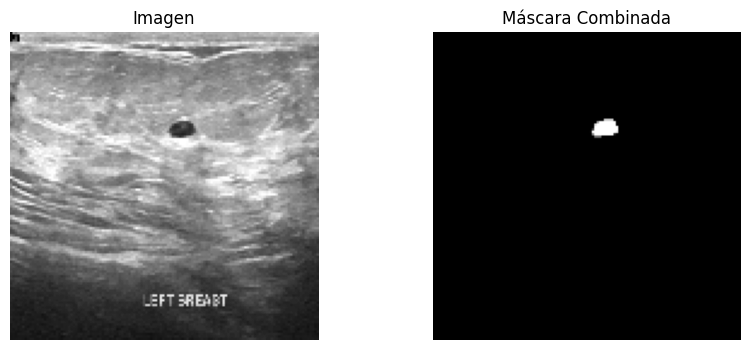

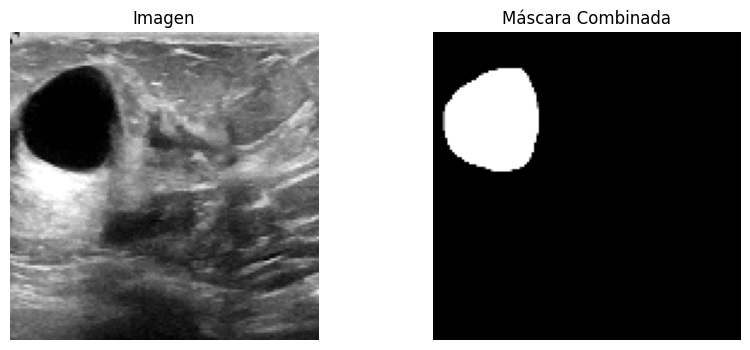

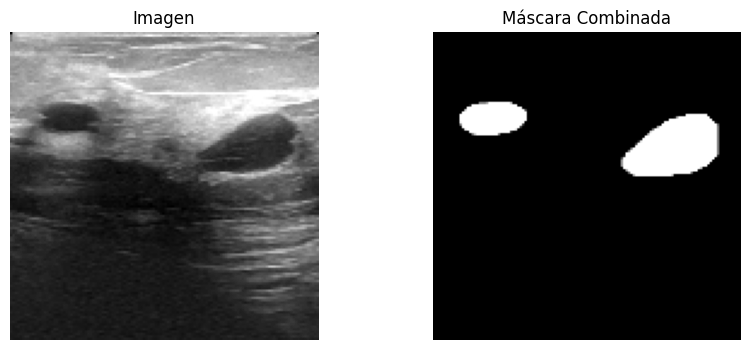

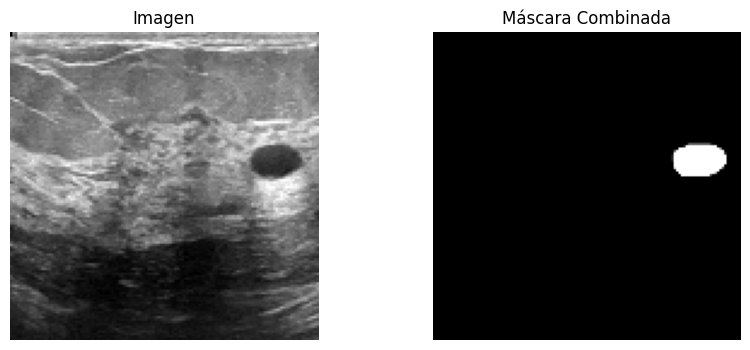

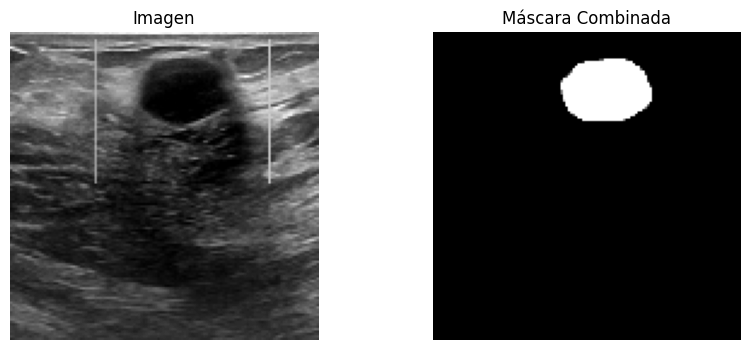

In [4]:
# Asegurarse de que cada imagen tenga una máscara correspondiente
assert len(imagenes) == len(mascaras_combinadas), "El número de imágenes y máscaras combinadas debe ser el mismo."

# Mostrar las primeras n imágenes y máscaras para verificar que estén correctamente emparejadas
n = 5
for i in range(n):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(imagenes[i], cmap='gray')
    plt.title('Imagen')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mascaras_combinadas[i], cmap='gray')
    plt.title('Máscara Combinada')
    plt.axis('off')
    plt.show()


- **Verificación de Correspondencia entre Imágenes y Máscaras**:
  - La línea `assert len(imagenes) == len(mascaras_combinadas)` se asegura de que el número de imágenes sea igual al número de máscaras combinadas. Si los números no coinciden, el código mostrará un error.

- **Visualización de Imágenes y Máscaras**:
  - Este bloque de código muestra las primeras n imágenes y sus máscaras combinadas correspondientes para verificar visualmente que están correctamente emparejadas.
  - Para cada imagen y máscara, se crea una figura (`plt.figure`) y se muestran lado a lado (`plt.subplot(1, 2, 1)` para la imagen y `plt.subplot(1, 2, 2)` para la máscara).
  - `plt.imshow` se usa para mostrar la imagen y la máscara, y `plt.title` agrega un título a cada subfigura. `plt.axis('off')` elimina los ejes para una visualización más limpia.
  - `plt.show()` muestra la figura creada con la imagen y su máscara.


# Preprocesamiento de Datos

## Procesamiento y Preparación de Imágenes y Máscaras

In [5]:
# Normalizar las imágenes y máscaras a una escala de 0 a 1
imagenes_norm = imagenes.astype('float32') / 255.0
mascaras_norm = mascaras_combinadas.astype('float32') / 255.0

# Asegurarse de que las máscaras tengan una cuarta dimensión (necesario para keras)
mascaras_norm = np.expand_dims(mascaras_norm, axis=-1)

print("Forma de las imágenes normalizadas:", imagenes_norm.shape)
print("Forma de las máscaras normalizadas:", mascaras_norm.shape)


Forma de las imágenes normalizadas: (780, 128, 128)
Forma de las máscaras normalizadas: (780, 128, 128, 1)


- **Normalización de Imágenes y Máscaras**:
  - `imagenes_norm = imagenes.astype('float32') / 255.0`: Convierte las imágenes a un formato de número decimal (`float32`) y las normaliza dividiéndolas por 255. Esto cambia el rango de los valores de píxeles de 0-255 a 0-1.
  - `mascaras_norm = mascaras_combinadas.astype('float32') / 255.0`: Realiza la misma operación de conversión y normalización para las máscaras.

- **Añadir una Cuarta Dimensión a las Máscaras**:
  - `mascaras_norm = np.expand_dims(mascaras_norm, axis=-1)`: Añade una dimensión adicional a las máscaras. Muchas redes neuronales en Keras esperan que los datos tengan una dimensión adicional para los canales (incluso si es un solo canal, como en las imágenes en escala de grises). Esta línea asegura que las máscaras tengan el formato adecuado.

- **Verificación de Formas**:
  - Las líneas con `print` muestran las dimensiones (forma) de los arrays de imágenes y máscaras normalizadas. 


## División del Conjunto de Datos en Entrenamiento, Validación y Prueba

In [6]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_norm, mascaras_norm, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Mostrar las dimensiones de los conjuntos para verificar
print('Tamaño del conjunto de entrenamiento:', X_train.shape, y_train.shape)
print('Tamaño del conjunto de validación:', X_val.shape, y_val.shape)
print('Tamaño del conjunto de prueba:', X_test.shape, y_test.shape)


Tamaño del conjunto de entrenamiento: (468, 128, 128) (468, 128, 128, 1)
Tamaño del conjunto de validación: (156, 128, 128) (156, 128, 128, 1)
Tamaño del conjunto de prueba: (156, 128, 128) (156, 128, 128, 1)


- **División de Datos en Conjuntos de Entrenamiento y Prueba**:
  - `train_test_split(imagenes_norm, mascaras_norm, test_size=0.2, random_state=42)`: 
    - Esta línea divide las imágenes y máscaras normalizadas en dos grupos: uno para entrenamiento (`X_train`, `y_train`) y otro para pruebas (`X_test`, `y_test`).
    - `test_size=0.2` indica que el 20% de los datos se reservan para el conjunto de prueba.
    - `random_state=42` asegura que la división sea la misma cada vez que se ejecute el código.

- **División Adicional para Validación**:
  - `train_test_split(X_train, y_train, test_size=0.25, random_state=42)`: 
    - Esta línea toma el conjunto de entrenamiento previamente definido y lo divide nuevamente para crear un conjunto de validación (`X_val`, `y_val`).
    - `test_size=0.25` significa que el 25% del conjunto de entrenamiento se convierte en el conjunto de validación. Esto corresponde al 20% del total de datos (0.25 * 0.8 = 0.2).

- **Verificación de Tamaños de los Conjuntos**:
  - Las líneas con `print` muestran las dimensiones de los conjuntos de entrenamiento, validación y prueba para verificar que la división de datos se ha realizado correctamente y que las proporciones son las esperadas.


# Aumento de Datos (Data Augmentation)

In [7]:
# Asegurarse de que X_train y y_train tengan 4 dimensiones
X_train_expanded = np.expand_dims(X_train, axis=-1)
y_train_expanded = np.expand_dims(y_train, axis=-1)

print("Forma de X_train expandida:", X_train_expanded.shape)
print("Forma de y_train expandida:", y_train_expanded.shape)


Forma de X_train expandida: (468, 128, 128, 1)
Forma de y_train expandida: (468, 128, 128, 1, 1)


- **Expansión de Dimensiones de los Conjuntos de Entrenamiento**:
  - `np.expand_dims(X_train, axis=-1)` y `np.expand_dims(y_train, axis=-1)`:
    - Estas líneas añaden una dimensión extra a los conjuntos de entrenamiento `X_train` (imágenes) y `y_train` (máscaras).
    - La expansión de dimensiones es necesaria porque las redes neuronales en Keras suelen esperar datos con una dimensión adicional para los canales (en este caso, imágenes en escala de grises con un solo canal).

- **Verificación de las Nuevas Dimensiones**:
  - Las líneas con `print` muestran las nuevas dimensiones (forma) de `X_train_expanded` y `y_train_expanded`.


In [8]:
y_train_expanded = y_train_expanded.reshape(y_train_expanded.shape[0], 128, 128, 1)

print("Forma corregida de y_train expandida:", y_train_expanded.shape)


Forma corregida de y_train expandida: (468, 128, 128, 1)


- **Reajuste de las Máscaras de Entrenamiento (`y_train_expanded`)**:
  - `y_train_expanded.reshape(y_train_expanded.shape[0], 128, 128, 1)`:
    - Esta línea cambia la forma de `y_train_expanded` para que tenga un formato específico: 128x128 píxeles con un solo canal.
    - Se utiliza `reshape` para reorganizar los datos en un array de NumPy, ajustando las máscaras a la forma que espera la red neuronal.

- **Verificación de la Forma Corregida**:
  - `print("Forma corregida de y_train expandida:", y_train_expanded.shape)`:
    - Imprime la nueva forma de `y_train_expanded` para confirmar que el ajuste se ha realizado correctamente.

- **Nota sobre la Razón del Reajuste**:
  - El cambio de forma se hizo necesario debido a que, después del paso de expansión de dimensiones, `y_train_expanded` tenía una forma extra de `(468, 128, 128, 1, 1)`. La quinta dimensión adicional no era necesaria y podía causar problemas en el entrenamiento de la red neuronal. Por lo tanto, se utilizó `reshape` para corregir esto, asegurando que las máscaras tengan la misma cantidad de dimensiones que las imágenes (`X_train_expanded`), que es `(468, 128, 128, 1)`.


In [9]:
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear ImageDataGenerator para imágenes y máscaras
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Definir la semilla
seed = 42  

# Ajustar los generadores
image_datagen.fit(X_train_expanded, augment=True, seed=seed)
mask_datagen.fit(y_train_expanded, augment=True, seed=seed)

# Combinar generadores
train_generator = zip(image_datagen.flow(X_train_expanded, batch_size=32, seed=seed),
                      mask_datagen.flow(y_train_expanded, batch_size=32, seed=seed))




- **Configuración de Data Augmentation (`data_gen_args`)**:
  - Aquí se definen varias formas de transformar las imágenes y máscaras para generar datos adicionales durante el entrenamiento. Incluye rotaciones, cambios en el ancho y alto, zoom y volteo horizontal.
  - `fill_mode='nearest'` determina cómo rellenar los nuevos píxeles que pueden aparecer después de la transformación.

- **Creación de Generadores de Data Augmentation**:
  - `ImageDataGenerator(**data_gen_args)`: Crea dos generadores de imágenes (uno para imágenes y otro para máscaras) usando las configuraciones definidas anteriormente. Estos generadores aplicarán las transformaciones de data augmentation de forma aleatoria a las imágenes y máscaras durante el entrenamiento.

- **Definición de una Semilla (`seed`)**:
  - `seed = 42`: Establece una semilla para que las transformaciones aleatorias aplicadas a las imágenes y las máscaras sean consistentes y correspondan entre sí.

- **Ajuste de los Generadores**:
  - `image_datagen.fit` y `mask_datagen.fit`: Ajustan los generadores a los datos de entrenamiento. Esto prepara a los generadores para aplicar las transformaciones de manera efectiva.

- **Combinación de Generadores para Entrenamiento (`train_generator`)**:
  - `zip(image_datagen.flow(...), mask_datagen.flow(...))`: Combina los dos generadores en uno. Esto asegura que cada lote de imágenes transformadas tenga las máscaras correspondientes también transformadas, manteniendo la relación entre imagen y máscara.


# Construcción del Modelo

Arquitectura U-Net
La arquitectura U-Net recibe su nombre por su forma de "U", que se caracteriza por tener un camino de contracción (codificador) y un camino de expansión (decodificador). A continuación, se describen sus componentes principales:

Camino de Contracción (Codificador):

Compuesto por una serie de capas convolucionales y de Max Pooling.
En cada etapa, la imagen se procesa con convoluciones, lo que permite a la red aprender las características complejas de la imagen. Luego, se aplica Max Pooling para reducir las dimensiones espaciales, aumentando la profundidad de las características aprendidas.
Este proceso captura la información contextual de la imagen.
Camino de Expansión (Decodificador):

Incluye capas convolucionales y operaciones de "upsampling" o deconvolución.
El objetivo es aumentar progresivamente la resolución espacial de las salidas.
En cada etapa del decodificador, se realiza una concatenación con las características correspondientes del codificador. Esto se conoce como "conexiones de salto" y ayuda a la red a recuperar la información espacial perdida durante el proceso de contracción.
Conexiones de Salto:

Son conexiones directas entre las capas del codificador y las del decodificador.
Permiten que la información de alta resolución del codificador se combine con la información semántica en el decodificador, mejorando la precisión de la localización en la segmentación.
Capa Final:

Una capa convolucional que reduce el número de canales a la cantidad deseada de clases de segmentación.
Por ejemplo, en una tarea de segmentación binaria, esta capa tendrá un solo canal de salida.

In [10]:
# Definir el bloque de codificación
def conv_block(input_tensor, num_filters):
    tensor = Conv2D(num_filters, (3,3), padding='same', activation='relu')(input_tensor)
    tensor = Conv2D(num_filters, (3,3), padding='same', activation='relu')(tensor)
    return tensor

# Definir el bloque de decodificación
def decoder_block(input_tensor, concat_tensor, num_filters):
    tensor = UpSampling2D((2, 2))(input_tensor)
    tensor = Concatenate(axis=-1)([tensor, concat_tensor])
    tensor = conv_block(tensor, num_filters)
    return tensor

# Construir el modelo U-Net
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Camino de contracción
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D((2, 2))(c4)

    # Parte central
    c5 = conv_block(p4, 256)

    # Camino de expansión
    d6 = decoder_block(c5, c4, 128)
    d7 = decoder_block(d6, c3, 64)
    d8 = decoder_block(d7, c2, 32)
    d9 = decoder_block(d8, c1, 16)

    # Salida
    outputs = Conv2D(1, (1,1), padding='same', activation='sigmoid')(d9)

    model = Model(inputs, outputs, name='U-Net')
    return model

# Crear el modelo U-Net
unet = unet_model(input_shape=(128, 128, 1))
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Bloques del Modelo U-Net

1. **Bloque de Codificación (Convolutional Block)**:
   - `conv_block`: Define una secuencia de dos capas convolucionales, cada una seguida por una activación ReLU. 
   - Se usa para extraer características de la imagen en diferentes niveles de complejidad.

2. **Bloque de Decodificación**:
   - `decoder_block`: Combina las características aprendidas durante la codificación con el camino de expansión.
   - Utiliza `UpSampling2D` para aumentar la dimensión espacial de las características.
   - `Concatenate` fusiona estas características ampliadas con las correspondientes del camino de contracción, ayudando a recuperar la información espacial perdida.

3. **Construcción del Modelo U-Net**:
   - `unet_model`: 
     - Crea un modelo U-Net utilizando los bloques de codificación y decodificación definidos anteriormente.
     - Comienza con la entrada (`inputs`) y aplica sucesivamente los bloques de codificación (`conv_block`) y Max Pooling para formar el camino de contracción.
     - La "parte central" es el punto más bajo de la "U", donde las características se comprimen al máximo.
     - Luego, el modelo se expande a través del camino de expansión, utilizando los `decoder_block`.
     - Finalmente, se aplica una última capa convolucional para generar la salida del modelo.

4. **Salida del Modelo**:
   - La capa de salida utiliza una convolución con un solo filtro y una activación 'sigmoid'. Esto es típico en tareas de segmentación binaria, donde se necesita una probabilidad por píxel de pertenecer a la región de interés.

5. **Compilación y Resumen del Modelo**:
   - El modelo se compila con el optimizador 'adam' y la pérdida 'binary_crossentropy', adecuados para tareas de segmentación binaria.
   - `metrics=['accuracy']` se usa para monitorear el rendimiento del modelo durante el entrenamiento.
   - `unet.summary()` proporciona un resumen detallado del modelo, mostrando cada capa, sus dimensiones y el número de parámetros.



# Entrenamiento del Modelo

In [11]:
# Parámetros de entrenamiento
num_epochs = 20 
batch_size = 32

# Entrenamiento del modelo
history = unet.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=num_epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/20
14/14 [==============================] - 16s 179ms/step - loss: 0.7717 - accuracy: 0.9156 - val_loss: 0.4615 - val_accuracy: 0.9173
Epoch 2/20
14/14 [==============================] - 3s 96ms/step - loss: 0.3311 - accuracy: 0.9142 - val_loss: 0.2914 - val_accuracy: 0.9173
Epoch 3/20
14/14 [==============================] - 1s 92ms/step - loss: 0.2719 - accuracy: 0.9189 - val_loss: 0.2845 - val_accuracy: 0.9173
Epoch 4/20
14/14 [==============================] - 1s 98ms/step - loss: 0.2722 - accuracy: 0.9134 - val_loss: 0.2562 - val_accuracy: 0.9173
Epoch 5/20
14/14 [==============================] - 1s 87ms/step - loss: 0.2508 - accuracy: 0.9130 - val_loss: 0.2268 - val_accuracy: 0.9173
Epoch 6/20
14/14 [==============================] - 1s 89ms/step - loss: 0.2262 - accuracy: 0.9190 - val_loss: 0.2335 - val_accuracy: 0.9173
Epoch 7/20
14/14 [==============================] - 1s 91ms/step - loss: 0.2192 - accuracy: 0.9138 - val_loss: 0.2049 - val_accuracy: 0.9173
Epoch 8/20


### Parámetros y Entrenamiento del Modelo U-Net

1. **Definición de Parámetros de Entrenamiento**:
   - `num_epochs`: Especifica el número de veces que el modelo pasará por todo el conjunto de entrenamiento. Aquí se establece en `20`.
   - `batch_size`: Define el número de muestras que se procesarán antes de actualizar los parámetros del modelo. Se fija en `32`.

2. **Proceso de Entrenamiento**:
   - Se utiliza el método `.fit` del modelo para entrenar la red.
   - `train_generator`: Proporciona los datos de entrenamiento con aumento de datos (`data augmentation`). Cada 'batch' de datos generados incluirá tanto imágenes como máscaras transformadas.
   - `steps_per_epoch`: Determina cuántos 'batches' de datos se utilizarán en cada época. Aquí se calcula como el número total de muestras en el conjunto de entrenamiento dividido por el `batch_size`.
   - `epochs=num_epochs`: Indica que el entrenamiento se realizará durante el número de épocas definido previamente.
   - `validation_data=(X_val, y_val)`: Especifica los datos de validación que se usarán para evaluar el rendimiento del modelo después de cada época.

Este código lanza el proceso de entrenamiento del modelo U-Net, donde el modelo aprende gradualmente a segmentar las imágenes utilizando tanto los datos de entrenamiento como los de validación. El historial de entrenamiento (`history`) se guarda para analizar posteriormente el rendimiento del modelo durante las épocas.


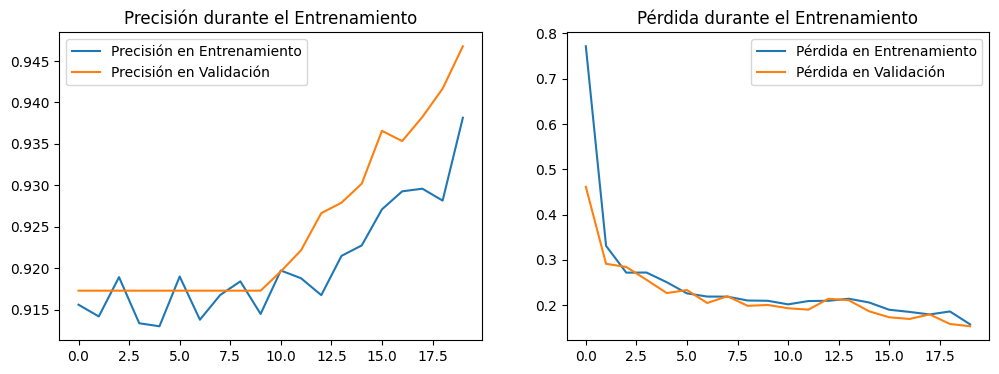

In [12]:
# Gráfico de la precisión y la pérdida durante el entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.title('Precisión durante el Entrenamiento')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()

plt.show()


### Visualización del Progreso del Entrenamiento

Esta sección del código crea gráficos para visualizar cómo la precisión y la pérdida del modelo evolucionaron durante el proceso de entrenamiento.

1. **Gráfico de Precisión**:
   - Muestra cómo la precisión (la proporción de predicciones correctas) cambió durante el entrenamiento tanto para el conjunto de entrenamiento como para el de validación.
   - `plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')`: Toma los datos de precisión del entrenamiento del objeto `history` y los grafica.
   - `plt.plot(history.history['val_accuracy'], label='Precisión en Validación')`: Hace lo mismo para los datos de precisión de validación.
   - Se agrega un título y una leyenda para clarificar lo que se muestra en el gráfico.

2. **Gráfico de Pérdida**:
   - Muestra cómo la pérdida (una medida del error del modelo) cambió a lo largo de las épocas de entrenamiento.
   - `plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')`: Grafica la pérdida en el conjunto de entrenamiento.
   - `plt.plot(history.history['val_loss'], label='Pérdida en Validación')`: Grafica la pérdida en el conjunto de validación.
   - Al igual que con el gráfico de precisión, se incluyen título y leyenda para una mejor interpretación.



# Evaluación del Modelo

Evaluacion del modelo en el conjunto de pruebas 

In [13]:
# Evaluar el modelo en el conjunto de prueba
evaluacion = unet.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {evaluacion[0]}')
print(f'Precisión en el conjunto de prueba: {evaluacion[1]}')


5/5 [==============================] - 0s 18ms/step - loss: 0.1571 - accuracy: 0.9433
Pérdida en el conjunto de prueba: 0.15705308318138123
Precisión en el conjunto de prueba: 0.9432560801506042


### Evaluación del Modelo en el Conjunto de Prueba


1. **Evaluación del Modelo**:
   - `unet.evaluate(X_test, y_test)`: Esta línea de código utiliza el método `.evaluate` para calcular la pérdida y precisión del modelo en el conjunto de prueba.
   - `X_test` y `y_test` representan las imágenes y máscaras del conjunto de prueba, respectivamente.

2. **Resultados de la Evaluación**:
   - La función `evaluate` devuelve una lista, donde el primer elemento es la pérdida (`loss`) y el segundo es la precisión (`accuracy`).
   - `print(f'Pérdida en el conjunto de prueba: {evaluacion[0]}')`: Muestra la pérdida del modelo en el conjunto de prueba.
   - `print(f'Precisión en el conjunto de prueba: {evaluacion[1]}')`: Muestra la precisión del modelo en el conjunto de prueba.




Visualización de Resultados de Segmentación y Comparación con las Máscaras Reales

5/5 [==============================] - 0s 17ms/step


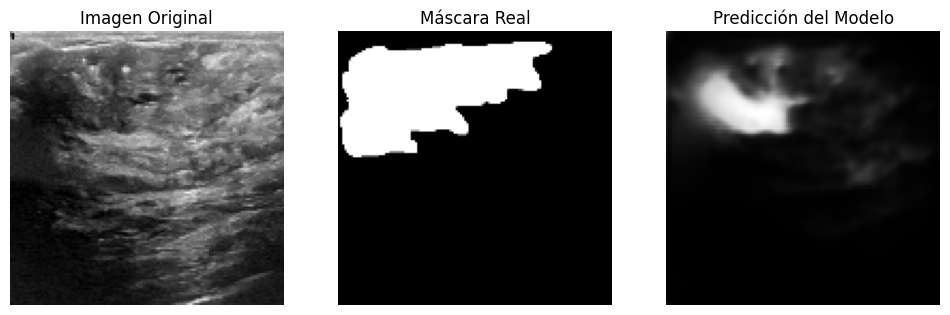

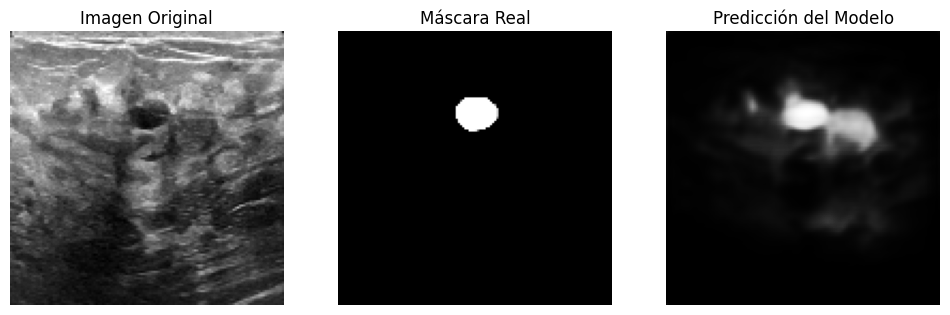

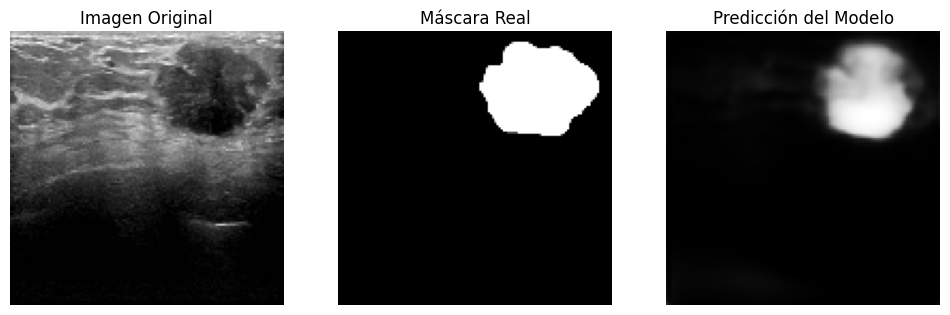

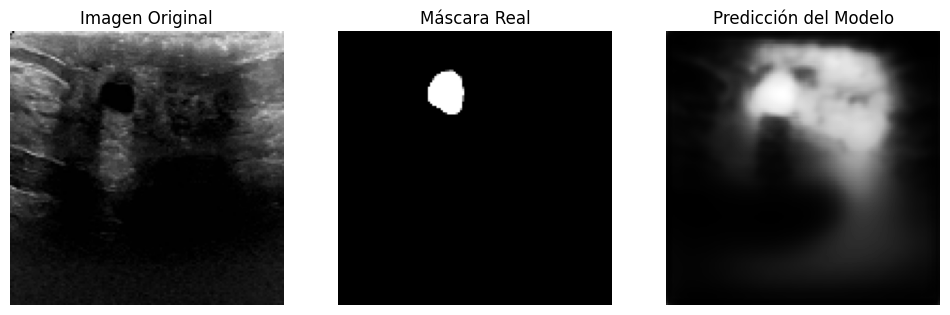

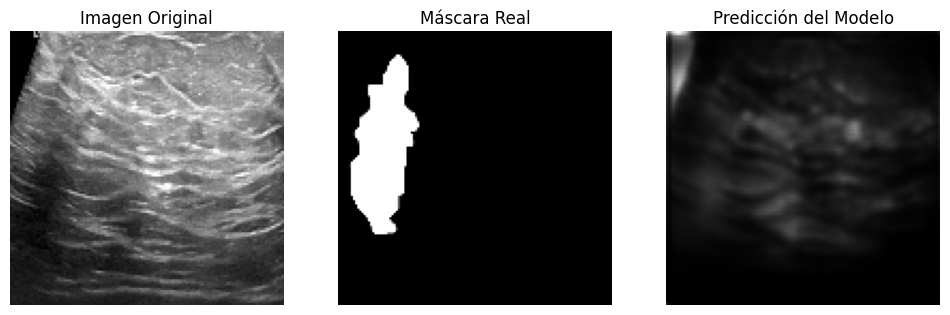

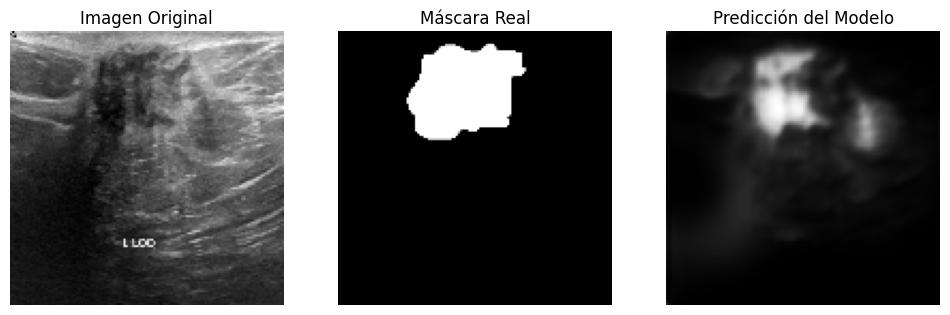

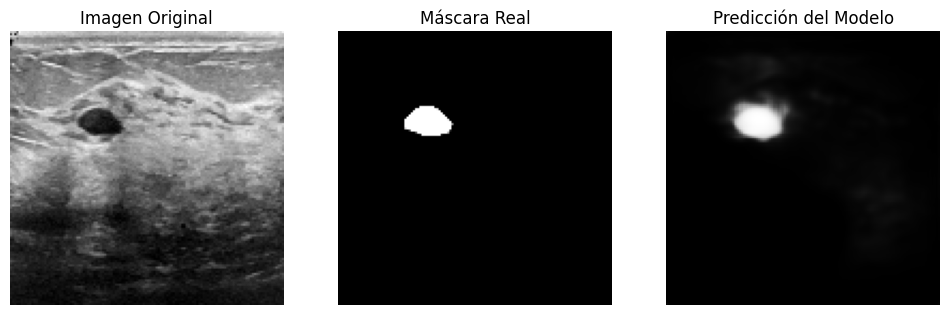

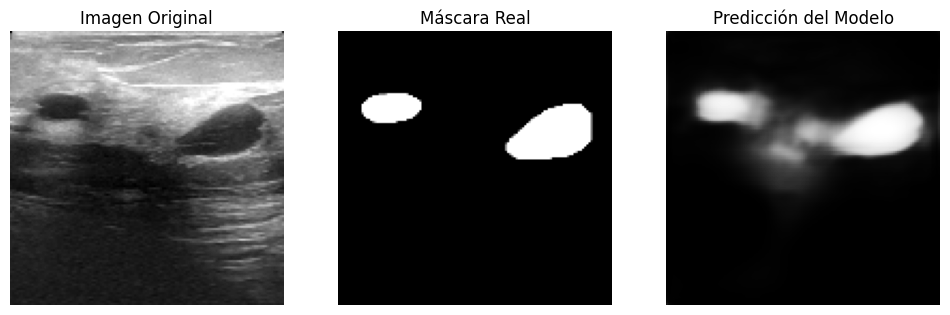

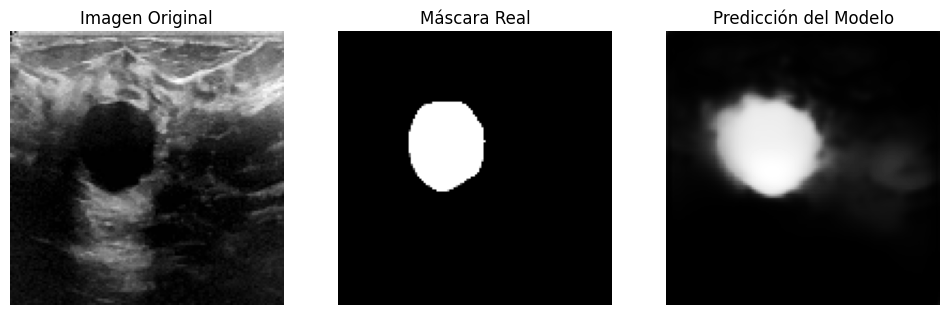

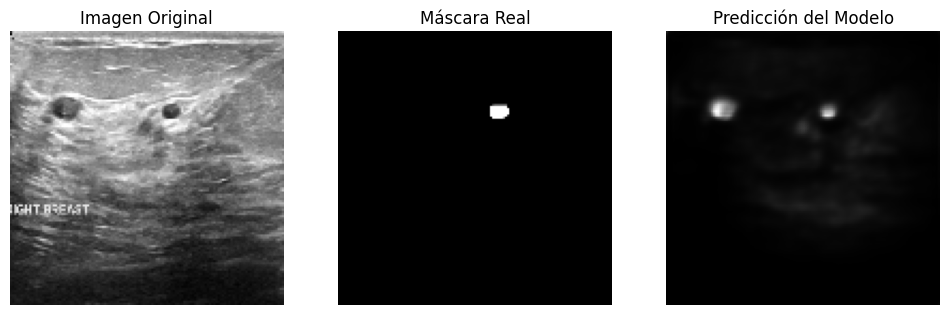

In [14]:
# Realizar predicciones en el conjunto de prueba
predicciones = unet.predict(X_test)

# Visualizar algunas predicciones
num_muestras = 10  # Ajustar segun las muestras 
indices = np.random.choice(range(len(X_test)), num_muestras, replace=False)

for i in indices:
    plt.figure(figsize=(12, 6))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Máscara real
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title('Máscara Real')
    plt.axis('off')

    # Predicción del modelo
    plt.subplot(1, 3, 3)
    plt.imshow(predicciones[i].squeeze(), cmap='gray')
    plt.title('Predicción del Modelo')
    plt.axis('off')

    plt.show()


### Visualización de Predicciones del Modelo U-Net


1. **Realización de Predicciones**:
   - `unet.predict(X_test)`: Utiliza el método `.predict` para generar predicciones de segmentación para cada imagen en el conjunto de prueba.
   - Las predicciones son máscaras generadas por el modelo, indicando las áreas de interés.

2. **Selección de Muestras para Visualización**:
   - Se seleccionan al azar `num_muestras` (10 en este caso) imágenes del conjunto de prueba para la visualización.
   - `np.random.choice` se usa para seleccionar índices aleatorios sin repetición.

3. **Visualización de Imágenes, Máscaras Reales y Predicciones**:
   - Para cada muestra seleccionada, se crean tres subfiguras:
     - **Imagen Original**: Muestra la imagen real del conjunto de prueba.
     - **Máscara Real**: Muestra la máscara real correspondiente a la imagen (la verdad de terreno).
     - **Predicción del Modelo**: Muestra la máscara predicha por el modelo U-Net.
   - `plt.imshow` se utiliza para mostrar cada imagen/máscara, y `plt.title` añade títulos descriptivos.
   - `plt.axis('off')` se usa para ocultar los ejes para una presentación más clara.


